<a href="https://colab.research.google.com/github/deenukhan/airbnb_new_user_bookings_case_study/blob/main/airbnb_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About Data

<p>In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be.&nbsp;All the users in this dataset are from&nbsp;the USA.</p>

<p>There are 12 possible outcomes of the destination country:&nbsp;'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and&nbsp;'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.</p>

<p>The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after <strong>7/1/2014 (note: this is updated on 12/5/15 when the competition restarted)</strong>.&nbsp;In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010.&nbsp;</p>

<h3>Data Files descriptions</h3>
<ul>
<li><strong>train_users.csv</strong>&nbsp;- the training set of users</li>
<li><strong>test_users.csv</strong> - the test set of users</li>
<ul>
<li>id: user id</li>
<li>date_account_created: the date of account creation</li>
<li>timestamp_first_active: timestamp of the first activity, note that it can be earlier than&nbsp;date_account_created or&nbsp;date_first_booking because a user can search before signing up</li>
<li>date_first_booking: date of first booking</li>
<li>gender</li>
<li>age</li>
<li>signup_method</li>
<li>signup_flow:&nbsp;the page a user came to signup up from</li>
<li>language: international language preference</li>
<li>affiliate_channel:&nbsp;what kind of paid marketing</li>
<li>affiliate_provider:&nbsp;where the marketing is e.g. google, craigslist, other</li>
<li>first_affiliate_tracked:&nbsp;whats the first marketing the user interacted with before the signing up</li>
<li>signup_app</li>
<li>first_device_type</li>
<li>first_browser</li>
<li>country_destination: this is the <strong>target variable</strong> you are to predict</li>
</ul>
<li><strong>sessions.csv</strong> -&nbsp;web sessions log for users</li>
<ul>
<li>user_id: to be joined with the column 'id' in users table</li>
<li>action</li>
<li>action_type</li>
<li>action_detail</li>
<li>device_type</li>
<li>secs_elapsed</li>
</ul>
<li><strong>countries.csv&nbsp;</strong>- summary statistics of destination countries in this dataset and their locations</li>
<li><strong>age_gender_bkts.csv</strong> - summary statistics of users' age group, gender, country of destination</li>
<li><strong>sample_submission.csv</strong> -&nbsp;correct format for submitting your predictions</li>
</ul>

## Extracting Data

In [ ]:
#Below code is just to copy all the files into current session's drive and creating and deleting few required folders

import os
import zipfile
from tqdm import tqdm

!mkdir airbnb_data
!mkdir temp
!cp "/content/drive/My Drive/Study/Case Study 1/airbnb_data/airbnb_data.zip" /content/

#-q is oppsoite of verbose, -d for decompressing to directory
!unzip -q /content/airbnb_data.zip -d /content/temp/

for zip_files in tqdm(os.listdir('/content/temp')):
    path = os.path.join("/content/temp", zip_files)
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall("/content/airbnb_data")
    os.remove(path)

os.remove("/content/airbnb_data.zip")
os.rmdir("/content/temp")

100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


## Reading the Data

In [ ]:
#Importing Libraries
import os
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer

#Base Learners
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [ ]:
#Reading the data
age_gender = pd.read_csv('/content/airbnb_data/age_gender_bkts.csv')
countries = pd.read_csv('/content/airbnb_data/countries.csv')
sessions = pd.read_csv('/content/airbnb_data/sessions.csv')
train_users = pd.read_csv('/content/airbnb_data/train_users_2.csv')
test_users = pd.read_csv('/content/airbnb_data/test_users.csv')

## Exploratory Data Analysis

**Most important thing to keep in mind is that, all of our EDA should be alligned to our Target variable, means what is affecting our Target Variable**

In [ ]:
#First Let's Checkout the Shape of our datasets
print("Shape of Training data   : ", train_users.shape)
print("Shape of Testing data    : ", test_users.shape)
print("Shape of Countries data  : ", countries.shape)
print("Shape of AgeGender data  : ", age_gender.shape)
print("Shape of Sessions data   : ", sessions.shape)

Shape of Training data   :  (213451, 16)
Shape of Testing data    :  (62096, 15)
Shape of Countries data  :  (10, 7)
Shape of AgeGender data  :  (420, 5)
Shape of Sessions data   :  (10567737, 6)


In [ ]:
#Let's check out some basic inofrmation about the data
train_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

1. **We have 213451 Entries with 16 columns, 15 being indepnedant variables and "country_destination" being dependent variable**

In [ ]:
test_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       62096 non-null  object 
 1   date_account_created     62096 non-null  object 
 2   timestamp_first_active   62096 non-null  int64  
 3   date_first_booking       0 non-null      float64
 4   gender                   62096 non-null  object 
 5   age                      33220 non-null  float64
 6   signup_method            62096 non-null  object 
 7   signup_flow              62096 non-null  int64  
 8   language                 62096 non-null  object 
 9   affiliate_channel        62096 non-null  object 
 10  affiliate_provider       62096 non-null  object 
 11  first_affiliate_tracked  62076 non-null  object 
 12  signup_app               62096 non-null  object 
 13  first_device_type        62096 non-null  object 
 14  first_browser         

1. **In Test data we can see we have 15 columns, obviosuly we don't have our target variable here as we have to predict that.**
2. **one more thing we can notice here is that, date_first_booking column is also given here which don't have any values and also doesn't make any sense to be in testing data, as user haven't booked the destination yet.**
3. **So we will be removing "date_first_booking" column from our training and testing data.**


In [ ]:
#Let's checkout how data looks like
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [ ]:
''' 
    let's find out, If we have null values or not
    But, there is one more thing we need to keep in mind, from looking the training data analysis we observed
    that we have some '-unknown-' values in our Gender and first_browser feature which is clearly not a gender nor browser
    so we will be replacing this '-unknown-' value with NaN and later deal with it accordingly
'''
#Replacing "-unknown-" values with Null values
train_users['gender'].replace({'-unknown-':np.nan}, inplace = True)
train_users['first_browser'].replace({'-unknown-':np.nan}, inplace = True)

null_values = train_users.isnull().sum()

#Checking how many features having how much null values
print("**************** Null Values in Training Data **************** ")
for index in range(0, len(null_values)):
    if null_values[index] > 0:
        print('{:.2f} % ({} of {}) datapoints are NaN in "{}" feature'.format((null_values[index]/len(train_users))*100,
                                                             null_values[index], len(train_users), train_users.columns[index] )) 

**************** Null Values in Training Data **************** 
58.35 % (124543 of 213451) datapoints are NaN in "date_first_booking" feature
44.83 % (95688 of 213451) datapoints are NaN in "gender" feature
41.22 % (87990 of 213451) datapoints are NaN in "age" feature
2.84 % (6065 of 213451) datapoints are NaN in "first_affiliate_tracked" feature
12.77 % (27266 of 213451) datapoints are NaN in "first_browser" feature


1. **Here we can see that, we have major Missing values in our date_first_booking and age feature, we will be removing date_first_booking feature and for rest feature's missing values we will dealt accordingly**

In [ ]:
#Let's Check out if our data is balanced or not
print(train_users['country_destination'].value_counts())

print("\n{:.2f} % People decided to visit US or not to visit at all".format((train_users['country_destination'].value_counts()[['NDF','US']].sum()/len(train_users))*100))
#This Shows 87.56 Percent of the users either decided to Travel to US or decided not to Travel at all

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

87.57 % People decided to visit US or not to visit at all


1. **Here we can notice that, dataset is highly imbalanced**
2. **Most of the user did not visit any destination and who decided to visit ,their destination was US**

In [ ]:
train_users.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


1. **Here we can observe , timestamp first active supposed to be in datetime format but it is not, and we have to convert it.**
2. **Second thing, we can observe, we have max age 2014 which is not possible and min age 1, which also not possbile, so we need to deal with them as well.**

####**date_account_created**

In [ ]:
#As this feature is releated to date object, first let's find out what exactly the type of this feature is in our dataset
#We are doing this because, if their type is not date or datetime, 
#we can convert them into date or datetime object and can use them much more effeciently
print('"date_account_created" type is   : ', type(train_users['date_account_created'][0]))

# Here we can see that feature is not having type as date or datetime, so we need to convert it into date feature 
# and we have already checked that this feature is not having any Null values so we are good to convert it

"date_account_created" type is   :  <class 'str'>


In [ ]:
#Converting to Str to datetime object, and our date is in "YYYY-MM-DD" format
train_users['date_account_created'] = pd.to_datetime(train_users['date_account_created'])

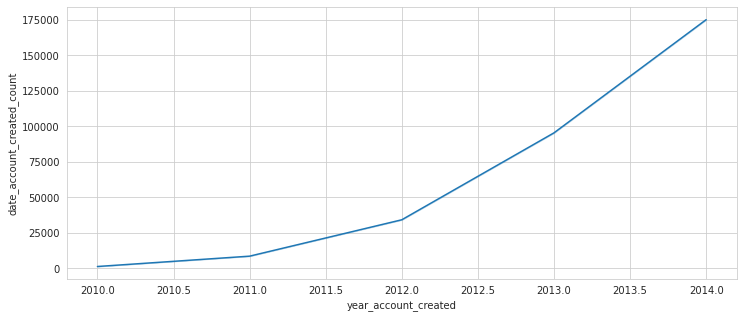

In [ ]:
train_users_copy = train_users.sort_values(by='date_account_created')
train_users_copy['date_account_created_count'] = 1
train_users_copy['date_account_created_count'] = train_users_copy['date_account_created_count'].cumsum()
train_users_copy['year_account_created'] =  pd.DatetimeIndex(train_users_copy['date_account_created']).year

sns.set_style('whitegrid')
figure(figsize=(12,5))
sns.lineplot(data = train_users_copy, x = 'year_account_created', y = 'date_account_created_count')

1. **Here we're trying to find the trend of user creation, if user creation is increasing by year or not.**
2. **So, for that we fetched year column from our date_account_created column and also created a date_account_created_count column which consists comulative sum of accounts created to that particular date.**
3. **We can clearly see here number of accounts creation is almost exponentialy increasing every year.**

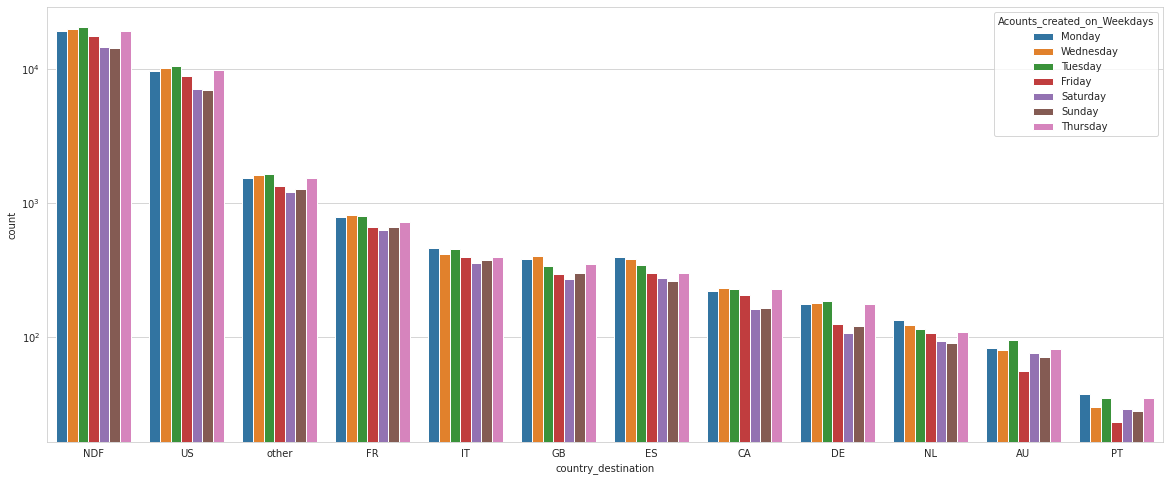

In [ ]:
#Lets plot the graph for country_destination, hued by Acounts_created_on_Weekdays and see if signup_method is affecting the choice of country
#Creating days Column from "timestamp_first_active" column

#Below one line of code is inspired by this https://stackoverflow.com/questions/29096381/num-day-to-name-day-with-pandas
train_users['Acounts_created_on_Weekdays'] = train_users['date_account_created'].apply(lambda day: dt.datetime.strftime(day, '%A'))
sns.set_style('whitegrid')
figure(figsize = (20,8))
sns.countplot(data = train_users, x = 'country_destination', hue = 'Acounts_created_on_Weekdays',
              order = train_users['country_destination'].value_counts().index).set_yscale('log')
train_users.drop(['Acounts_created_on_Weekdays'], inplace = True, axis = 1)

1. **Here we can observe that Most of the accounts are created on weekdays and lesser accounts are created on weekends**
2. **Netherlend (NL), Portugul (PT), Spain (ES) and Italy (IT) has more number of accounts created on Monday.**
3. **We also can see that Portugul (PT), and Australia has less number of account created on Friday's.**
4. **We can say weekday's are helpful in predicting the country_destination.**

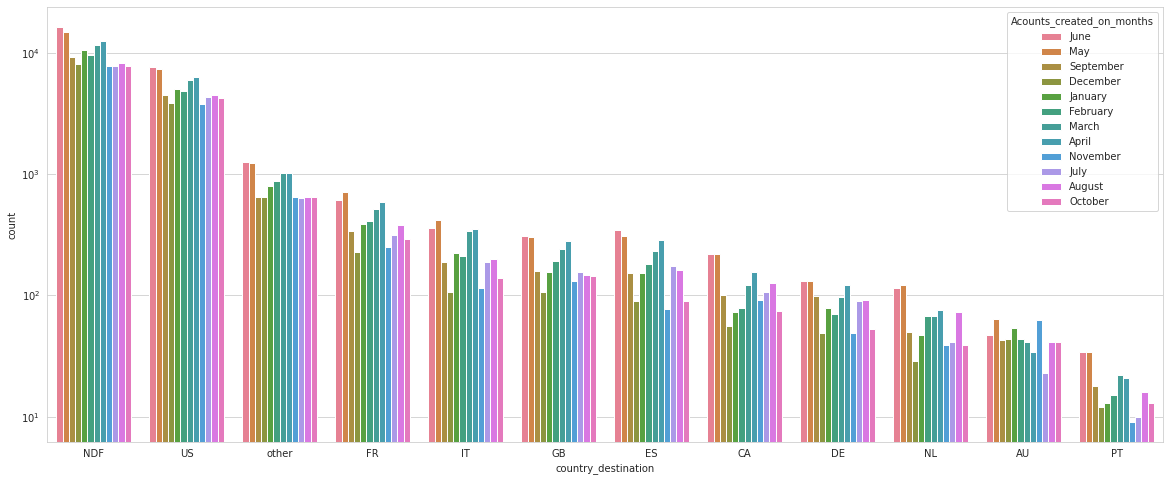

In [ ]:
#Lets plot the graph for country_destination, hued by Acounts_created_on_months and see if signup_method is affecting the choice of country
#Creating Year Column from "timestamp_first_active" column

#Below code is inspired by this https://stackoverflow.com/questions/29096381/num-day-to-name-day-with-pandas
train_users['Acounts_created_on_months'] = train_users['date_account_created'].apply(lambda month: dt.datetime.strftime(month, '%B'))
sns.set_style('whitegrid')
figure(figsize = (20,8))
sns.countplot(data = train_users, x = 'country_destination', hue = 'Acounts_created_on_months', palette = "husl",
              order = train_users['country_destination'].value_counts().index).set_yscale('log')
train_users.drop(['Acounts_created_on_months'], inplace = True, axis = 1)

1. **We can see in May France and Australia has more bookings than other countries.**
2. **In December US and Australia has more bookings than other countries.**
3. **From Above Graph we can see that Month is helping in deciding the choice of country.**

####**gender**

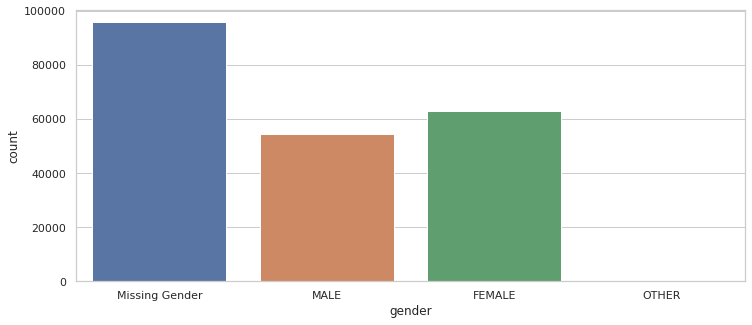

In [ ]:
#Let's Plot the graph of Gender and their count, just to check if Gender is affecting the booking or not booking choice
sns.set_style('whitegrid')
figure(figsize = (12,5))
sns.countplot(data = train_users, x = 'gender')

1. **Here we can see that there is not much difference between Male and Female user count. but Female Users are slightly more in count**
2. **and we have major chunk of our Gender data as Null value, so we need to take care of this later.**
3. **Now let's check if Gender is affecting the choice of country or choice of doing booking or not.**

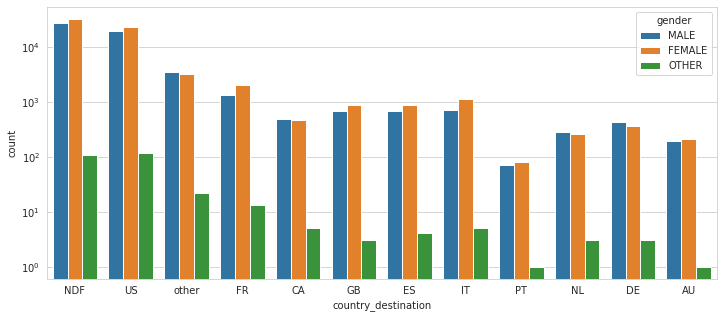

In [ ]:
#Let's plot the country_destination hued by gender, and check weather gender alone matters in predicting the country destination or not
sns.set_style('whitegrid')
figure(figsize = (12,5))
sns.countplot(data = train_users, x = 'country_destination', hue='gender').set_yscale('log')

1. **Here We can see that, it seems gender does not matter in choosing the country, Most of the people are likely to book for US or not to book at all.**
3. **So overall we can say that Gender is not much contributing to predict the country of choice of user.**

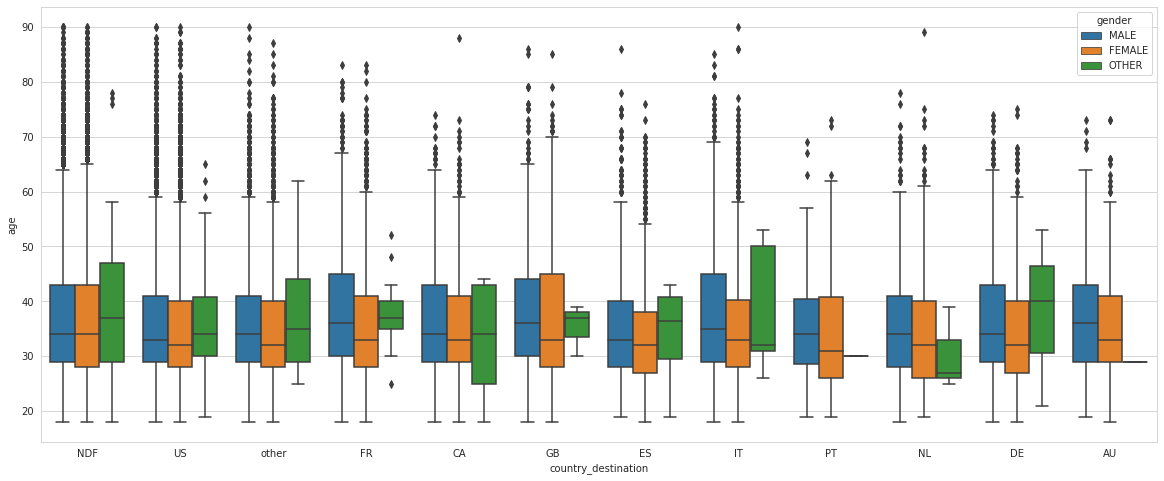

In [ ]:
#Checking if Gender and Age together are impacting the country choice
sns.set_style('whitegrid')
figure(figsize=(20, 8))
sns.boxplot(data = train_users, x = 'country_destination', y = 'age', hue= 'gender')

1. **Above Box Plot shows lot of information, we can se FR, CA, IT, DE and AU females are younger and males are older.**
2. **In Portugul and Australia Other category is almost nothing.**
3. **In United Kingdom (GB) Females are older and have more range.**

####**age**

In [ ]:
#As we have already seen above, that age column is having inconsistencies let's check them out
print("Minimum Age Given : ", train_users['age'].min()) 
print("Maximum Age Given : ", train_users['age'].max())

Minimum Age Given :  1.0
Maximum Age Given :  2014.0


1. **Here least age is 1 and max age is 2014 which is not possible, as minimum age requirement to book on airbnb is 18, check out the below link**
https://www.airbnb.co.in/help/article/2876/how-old-do-i-have-to-be-to-book-on-airbnb?locale=en&_set_bev_on_new_domain=1606819200_MDFhY2I5MzhlYjVm#:~:text=You%20must%20be%2018%20years,account%20to%20travel%20or%20host.
2. **Also the oldest person ever lived was of 122 Years, check out the below link**
https://www.guinnessworldrecords.com/news/2020/5/worlds-oldest-man-bob-weighton-dies-aged-112#:~:text=The%20oldest%20person%20ever%20to,days%20on%2012%20June%202013.


In [ ]:
#Now Let's checkout our age defaulters count
print("Users Count with Age > 122 : ", sum(train_users['age']>122))
print("Users Count with age < 18  : ", sum(train_users['age']<18))

'''
    One thing to notice as a common sense is, 122 or around, old person's chance to visit is very less 
    so we will take a number lesser than this (let's say 90) 
    and will replace all these values with Null for now, and later will use suitable technique to fill teses ages
'''

train_users['age'] = train_users['age'].apply(lambda age : np.nan if (age > 90 or age<18) else age)

Users Count with Age > 122 :  781
Users Count with age < 18  :  158


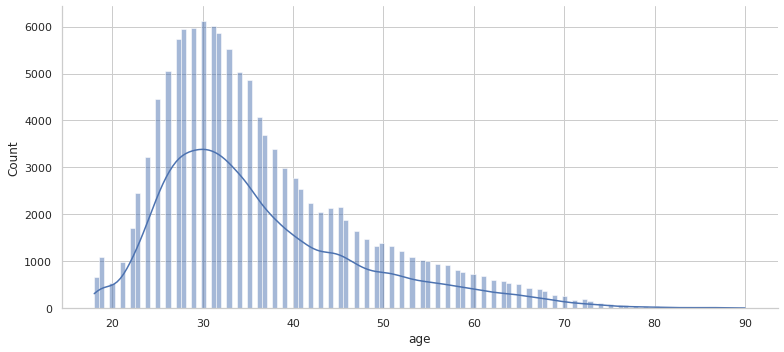

In [ ]:
#Let's checkout the distribution of the plot
sns.set_style("whitegrid")
sns.displot(train_users['age'].dropna(), kde = True, height = 5, aspect = 2.2, )

1. **From the above plot we can observe that most of the users are from age 25-45 But this doesn't tells us much about weather this information is helpful or not.**
2. **Let's check out if age has some preference of selecting country or not**

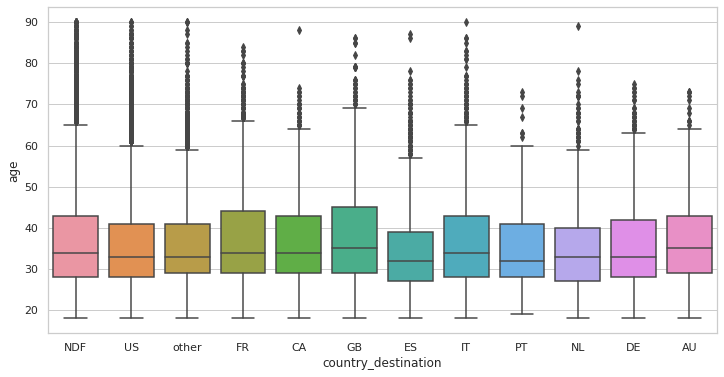

In [ ]:
#Let's check if age is contributing to choice of country or not, that is our main motive
sns.set_style('whitegrid')
figure(figsize=(12, 6))
sns.boxplot(data = train_users, x = 'country_destination', y = 'age')

1. **From the above box plot we can see that, People who are older than 40 are more likely to travel France (FR), Canada (CA), United Kingdom (UK), Australia (AU) and Italy (IT), German (DE)**
2. **People who are lesser than 40 are more likely to go to Spain (ES), Netherlands (NL)**

####**signup_method, and signup_flow**

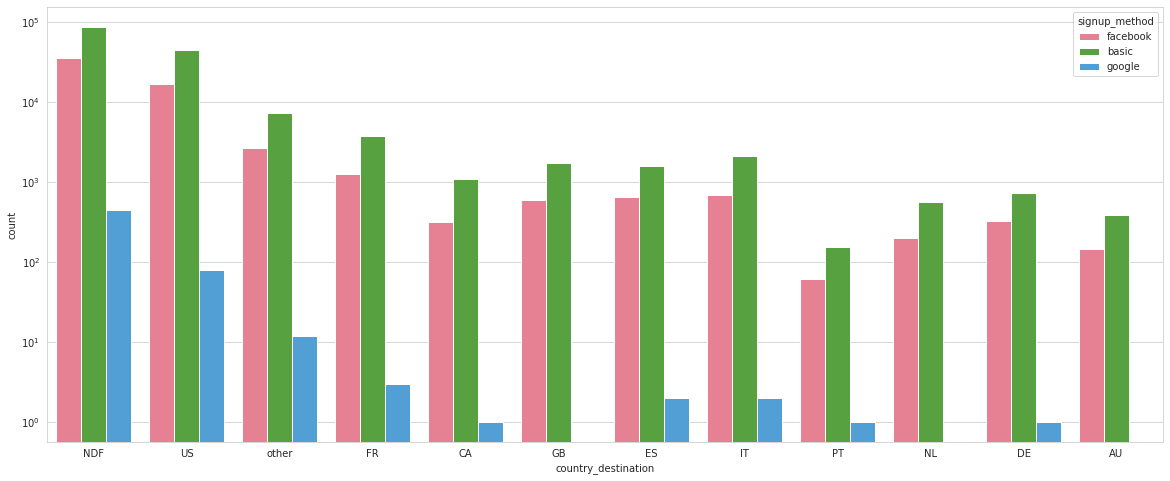

In [ ]:
#Lets plot the graph for country_destination, hued by signup_method and see if signup_method is affecting the choice of country
sns.set_style('whitegrid')
figure(figsize = (20,8))
sns.countplot(data = train_users, x = 'country_destination', hue='signup_method', palette = "husl").set_yscale('log')

1. **Here we can see that United kingdom and Netherlend and Australia doesn't have signup_method as google.**

2. **So, This feature also be slightly helpful.**

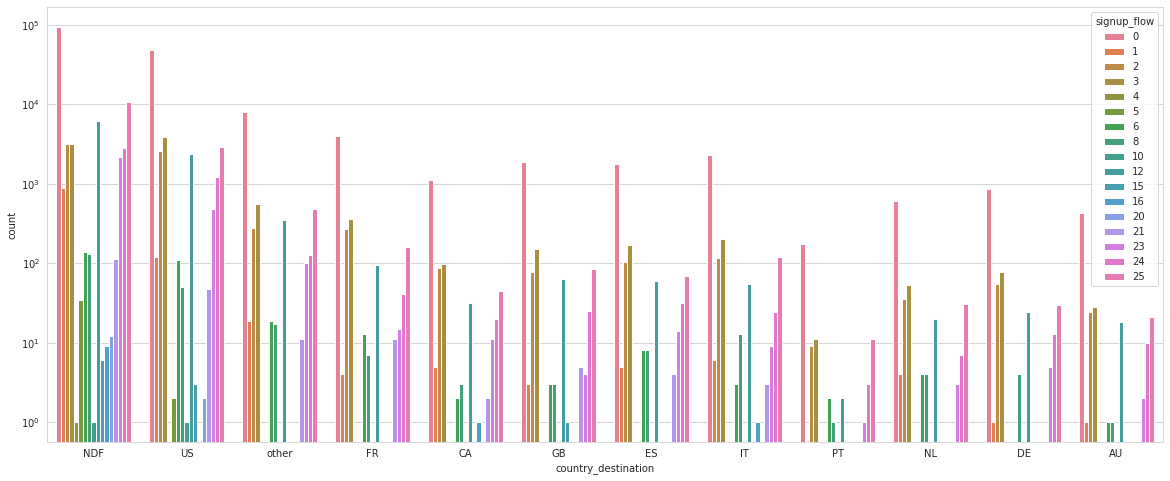

In [ ]:
#Lets plot the graph for country_destination, hued by signup_flow and see if signup_flow is affecting the choice of country
sns.set_style('whitegrid')
figure(figsize = (20,8))
sns.countplot(data = train_users, x = 'country_destination', hue='signup_flow', palette = "husl").set_yscale('log')

1. **Here we can see many noticable things, like if we see Netherlend we have 1 as signup flow but in Portugul we don't have signup flow, like this we have many examples.**

2. **So we can say that this is also helpfull in predicting the country.**


####**language**

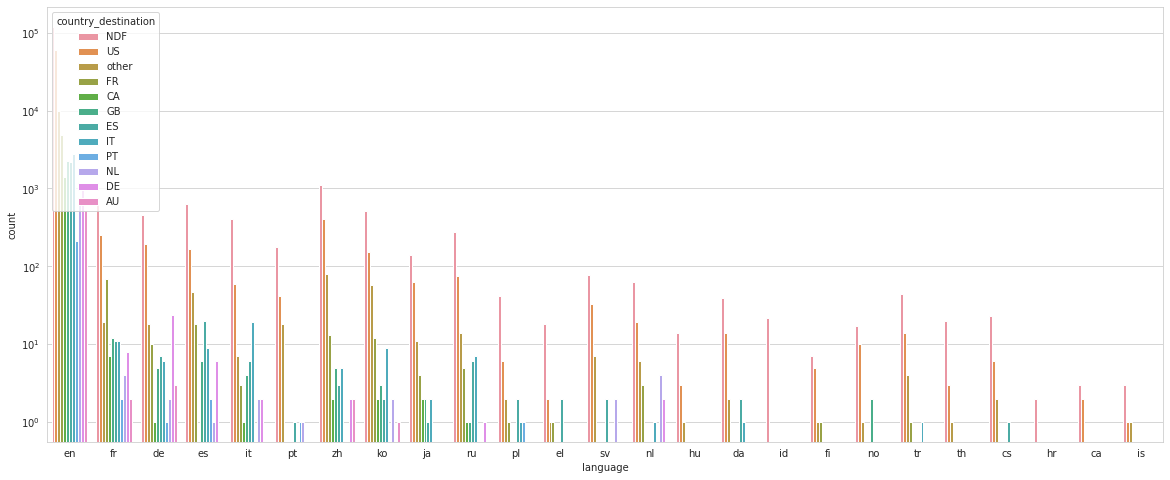

In [ ]:
#Lets plot the graph for country_destination, hued by language and see if language is affecting the choice of country
sns.set_style('whitegrid')
figure(figsize = (20,8))
sns.countplot(data = train_users, x = 'language', hue = 'country_destination').set_yscale('log')

1. **From the above graph we can see that, People who speaks Indonesian (id) and Croation (hr) made no bookings**

####**affiliate_channel, affiliate_provider, first_affiliate_tracked**

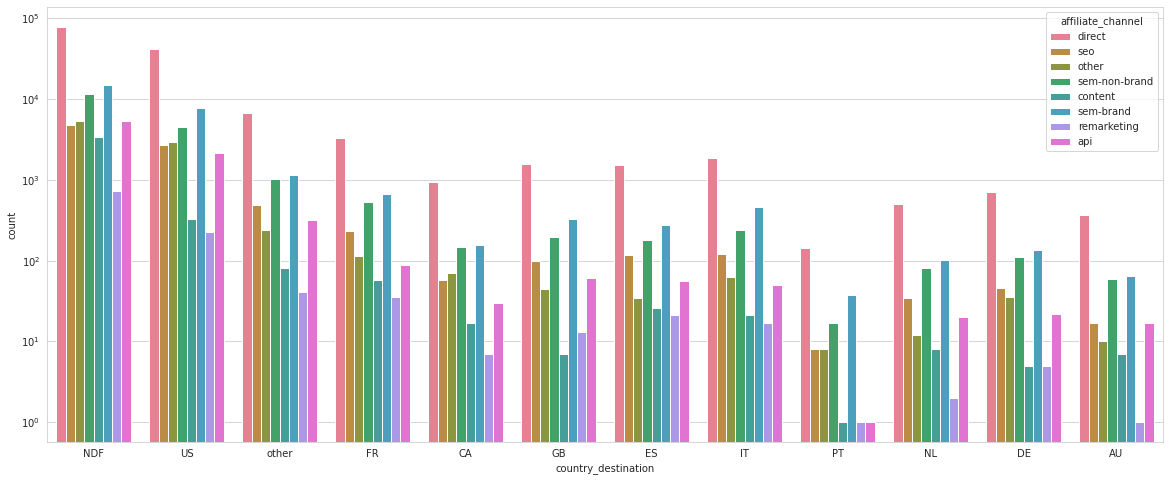

In [ ]:
#Lets plot the graph for country_destination, hued by affiliate_channel and see if affiliate_channel is affecting the choice of country
sns.set_style('whitegrid')
figure(figsize = (20,8))
sns.countplot(data = train_users, x = 'country_destination', hue='affiliate_channel', palette = "husl").set_yscale('log')

1. **Here We can see that United Kingdom (GB) has content affiliate channel is least used and in almost all other countries, remarketing is least used.**
2. **In Canada (CA), we can see that SEO is less used than others, in all other countries case is reversed.**
3. **From the above graph we can conclude that affiliate channel is helping in predicting the country.**


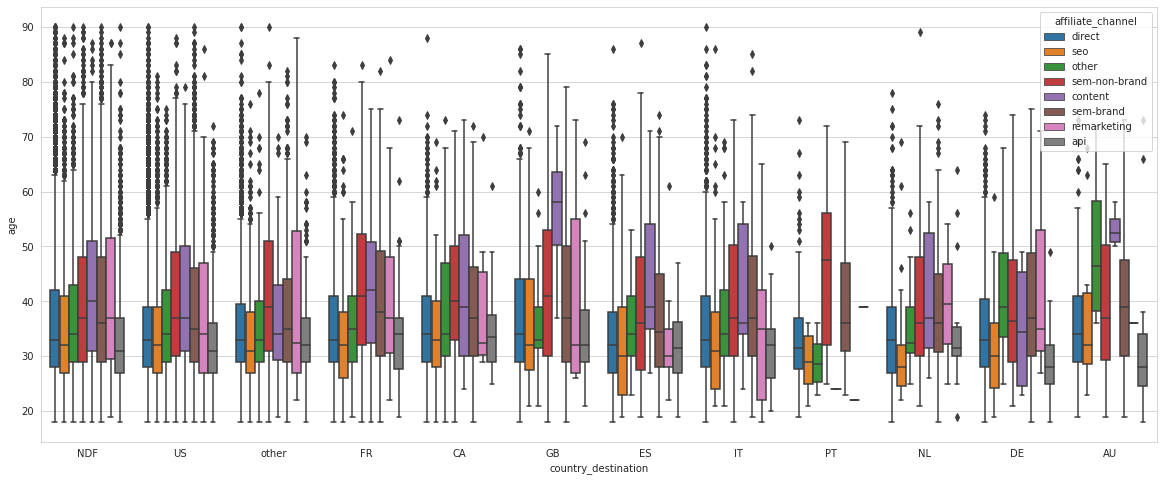

In [ ]:
#Let's check weather affiliate channel and age together will help us to predicting the country_destination or not.
sns.set_style('whitegrid')
figure(figsize=(20, 8))
sns.boxplot(data = train_users, x = 'country_destination', y = 'age', hue = 'affiliate_channel')

1. **From above box plot we have so much information, like in GB poeple who used content as their affiliate_channel are seems to be older.**
2. **In Germany (DE), poeple with api as their affiliate_channel are seems to be younger.**
3. **People Portugul (PT) with sem-non-brand as their affiliate_channel seems to be older.**
4. **Overall we can say that, affiliate channel and age together is good predictor of country_destination.**

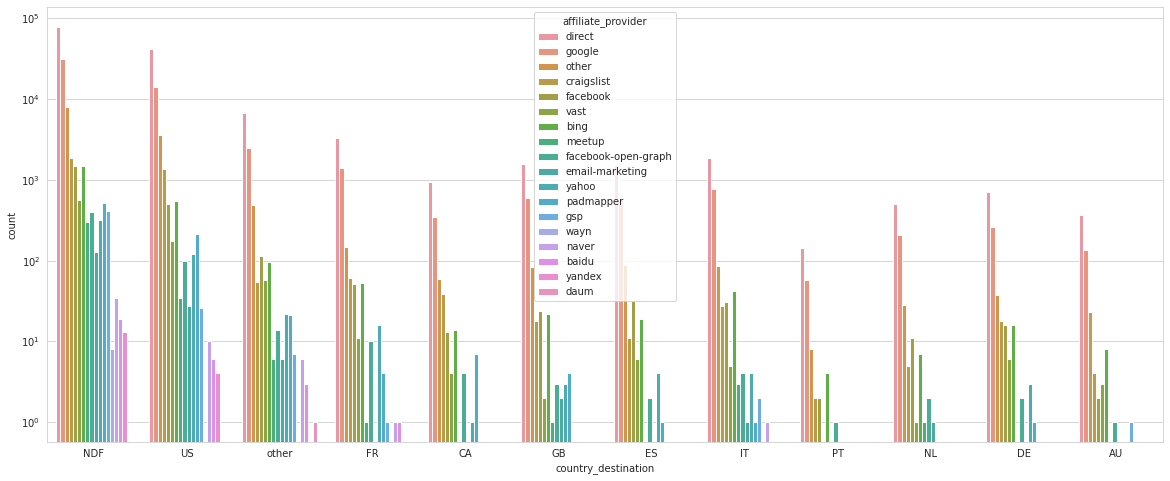

In [ ]:
#Lets plot the graph for country_destination, hued by affiliate_provider and see if affiliate_provider is affecting the choice of country
sns.set_style('whitegrid')
figure(figsize = (20,8))
sns.countplot(data = train_users, x = 'country_destination', hue='affiliate_provider').set_yscale('log')

1. **Here also we can see many important things like, in US we have 'baidu', 'yandex', 'daum' provider used, but in other countreis like Canda, United Kingdom, Portugul etc we don't have these providers.**
2. **So overall this feature is also a helping hand in predicting the country_destination.** 

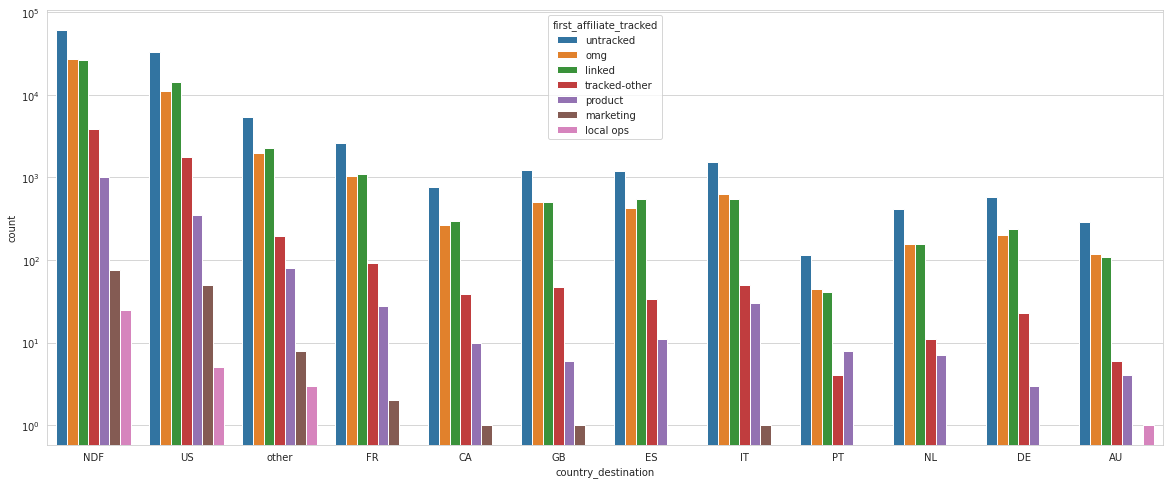

In [ ]:
#Lets plot the graph for country_destination, hued by first_affiliate_tracked and see if first_affiliate_tracked is affecting the choice of country
sns.set_style('whitegrid')
figure(figsize = (20,8))
sns.countplot(data = train_users, x = 'country_destination', hue='first_affiliate_tracked').set_yscale('log')

1. **Here also we can observe many things, like in Spain(ES), Netherlends (NL), Germany (DE), Australia, we don't have marketing.**
2. **local ops, we have only in US and Australia.**
3. S**o overall we can say this affiliate_first_tracked is also a good predictor of country_destination.**

####**first_browser, first_device_type**

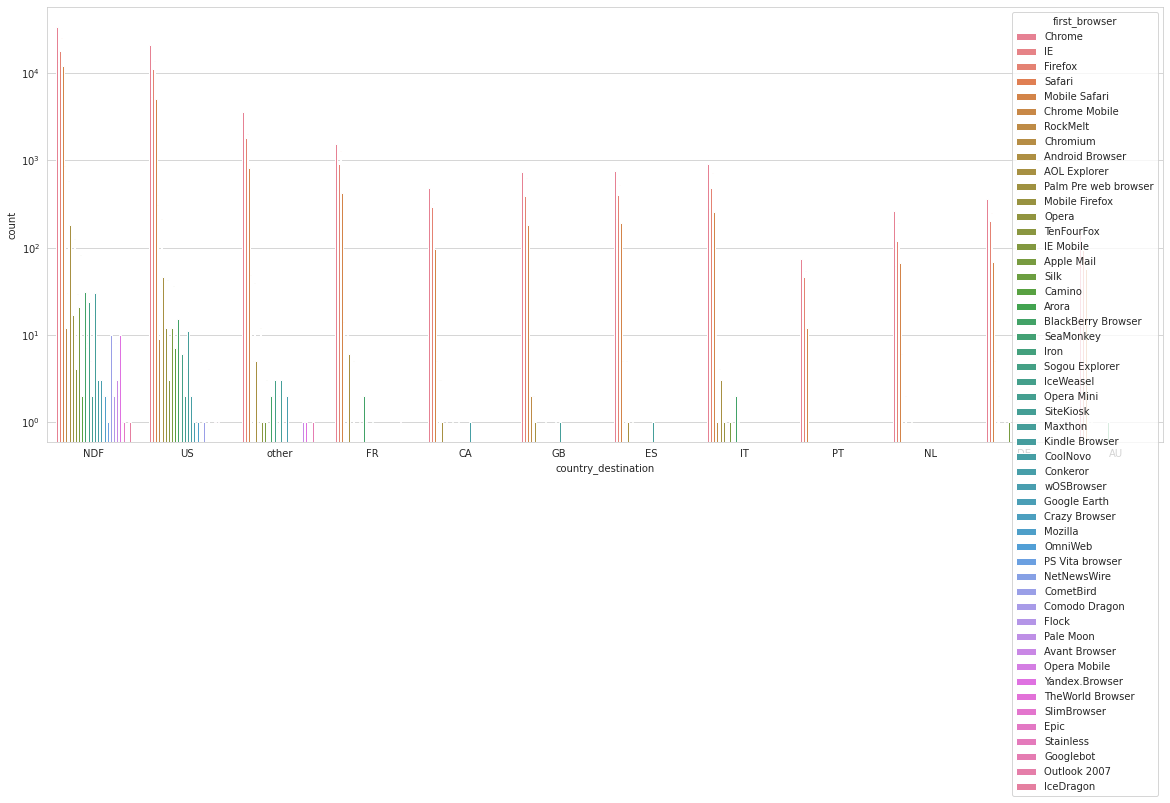

In [ ]:
#Lets plot the graph for country_destination, hued by first_browser and see if first_browser is affecting the choice of country
sns.set_style('whitegrid')
figure(figsize = (20,8))
sns.countplot(data = train_users, x = 'country_destination', hue='first_browser', palette = "husl").set_yscale('log')

1. **Here we can see that, most of the country has used only limited number of browser, like if se Portugul, only chrome, firefox and IE are used as a first_browser.**
2. **We can se US has many first_browser categories unlike other countries.**
3. **This feature will suerly help to predict the country destination.**

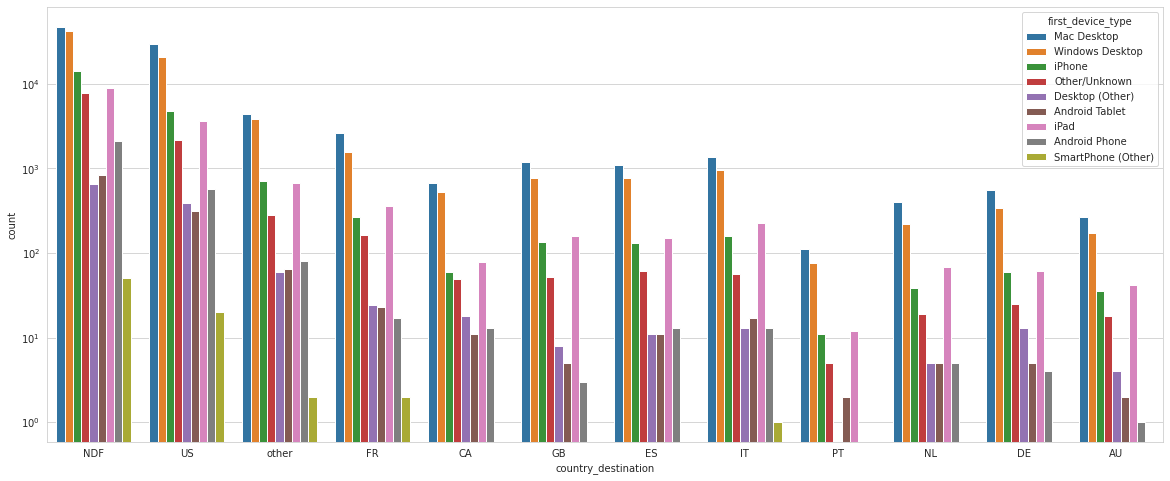

In [ ]:
#Lets plot the graph for country_destination, hued by first_device_type and see if first_device_type is affecting the choice of country
sns.set_style('whitegrid')
figure(figsize = (20,8))
sns.countplot(data = train_users, x = 'country_destination', hue='first_device_type',).set_yscale('log')

1. **First Device type is also helpful in predicting the country_destination, because we can see many countries like United Kingdom, Spain, Portugul doesn't have Smart Phone as first_device_type.**
2. **We can in US Android Phone is more used than United Kingdom.**

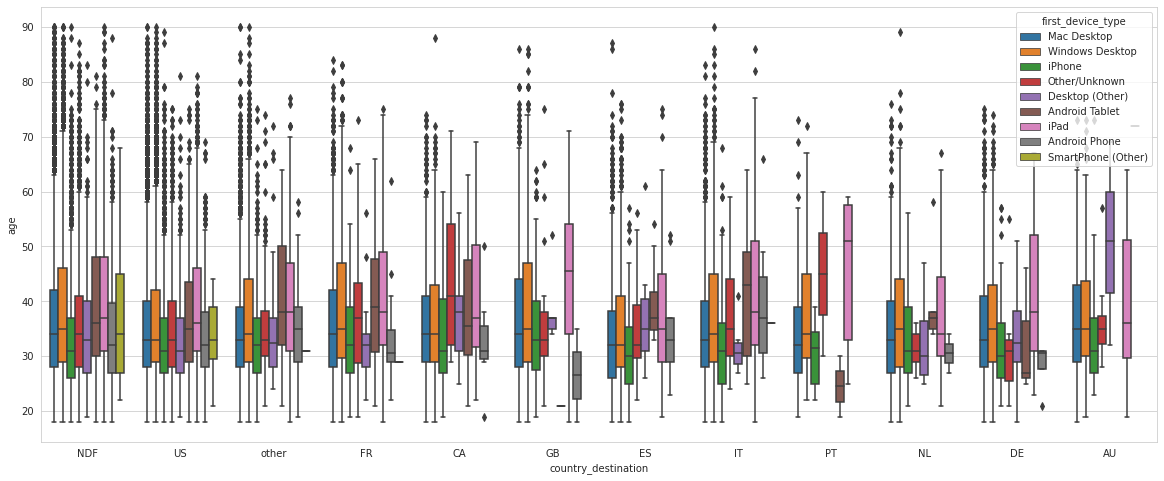

In [ ]:
#Let' se if first_device_type and age together will help us in predicting the country_destination or not.
sns.set_style('whitegrid')
figure(figsize=(20, 8))
sns.boxplot(data = train_users, x = 'country_destination', y = 'age', hue = 'first_device_type')

1. **Here we can see that, in Australia people aged between 40 - 60 are mostly using Desktop (other) as their first_device_type, which is uncommon for other countries.**
2. **Also, In United Kingdom and Portugul iPad is mostly used by older people.**
3. **In Portugul Android Table is used by younger people and United Kingdom Android Phone are used by Younger People.**
4. **So we can say Age and First_device_type are good predictior of country_destination.**

####**country_destination**

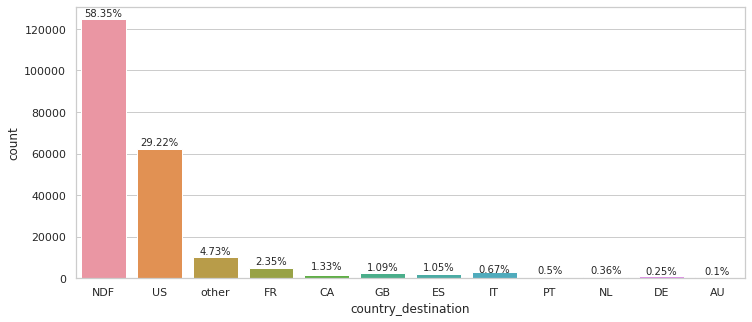

In [ ]:
#Now Let's checkout the target_variable.
#First Let's checkout t

sns.set_style('whitegrid')
figure(figsize=(12, 5))
sns.countplot(data=train_users, x = 'country_destination')

#let's Print the Percentage of of count as well
#Below code is inspired by https://www.kaggle.com/krutarthhd/airbnb-eda-and-xgboost
for country_index in range(train_users['country_destination'].nunique()):
    plt.text(country_index,  train_users['country_destination'].value_counts()[country_index] + 1500, 
             str(round((train_users['country_destination'].value_counts()[country_index]/total_datapoints) * 100, 2)) + "%", ha = 'center')

1. **Above graph is supporting our perivous statement that, most of the users either decided to travel to US or decided not to Travell at all**

## Test, Sessions, Age_Gender, Countries datafiles

#### Test Data

**All the preprocessing steps would be same for testing data as Training data, also we have already done major EDA on Training data and as features are same so we won't be spending much time on EDA of Testing data.**

In [ ]:
test_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       62096 non-null  object 
 1   date_account_created     62096 non-null  object 
 2   timestamp_first_active   62096 non-null  int64  
 3   date_first_booking       0 non-null      float64
 4   gender                   62096 non-null  object 
 5   age                      33220 non-null  float64
 6   signup_method            62096 non-null  object 
 7   signup_flow              62096 non-null  int64  
 8   language                 62096 non-null  object 
 9   affiliate_channel        62096 non-null  object 
 10  affiliate_provider       62096 non-null  object 
 11  first_affiliate_tracked  62076 non-null  object 
 12  signup_app               62096 non-null  object 
 13  first_device_type        62096 non-null  object 
 14  first_browser         

1. **Here We can see that we have date_first_booking column has zero values, and this doesn't make sense to have booking date in test data**
2. **So, we will be dropping this, also we can see that we also have Null values in age and first_affiliate_tracked column**
3. **So we also need to use same techniques to fill these missing values and conversion of features as we will use in training data**

In [ ]:
#Let's Checkou the Head of the Testing data
test_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [ ]:
''' 
    let's find out, If we have null values or not
    But, there is one more thing we need to keep in mind, from looking the Testing data analysis we observed
    that we have some '-unknown-' values in our Gender and first_browser feature which is clearly not a gender nor browser
    so we will be replacing this '-unknown-' value with NaN and later deal with it accordingly
'''
#Replacing "-unknown-" values with Null values
test_users['gender'].replace({'-unknown-':np.nan}, inplace = True)
test_users['first_browser'].replace({'-unknown-':np.nan}, inplace = True)

null_values = test_users.isnull().sum()

#Checking how many features having how much null values
print("**************** Null Values in Testing Data **************** ")
for index in range(0, len(null_values)):
    if null_values[index] > 0:
        print('{:.2f} % ({} of {}) datapoints are NaN in "{}" feature'.format((null_values[index]/len(test_users))*100,
                                                             null_values[index], len(test_users), test_users.columns[index] )) 

**************** Null Values in Training Data **************** 
100.00 % (62096 of 62096) datapoints are NaN in "date_first_booking" feature
54.42 % (33792 of 62096) datapoints are NaN in "gender" feature
46.50 % (28876 of 62096) datapoints are NaN in "age" feature
0.03 % (20 of 62096) datapoints are NaN in "first_affiliate_tracked" feature
27.58 % (17128 of 62096) datapoints are NaN in "first_browser" feature


1. **Here We can see date_first_booking has 100% Null values, which we have already discussed and will be removing this column from testing data.**
2. **Next things, we have missing values in gender, age, first_affiliate_tracked and first_browser.**
3. **We will be using same technique to fill these missing values which we will be using in Training data.**

In [ ]:
test_users.head()
#here also we can we have -unknown- value in gender and first_browser features.

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [ ]:
'''
Now let's check one of the important thing, let's find out if we have categories of any features in testing data 
which we haven't seen in training data
'''

categorical_columns = ['gender','signup_method', 'first_browser',
                        'language', 'affiliate_channel', 'affiliate_provider',
                        'first_affiliate_tracked', 'signup_app', 'first_device_type',
                        ]

flag = True
for column in categorical_columns:
    if (train_users[column].nunique()  == test_users[column].nunique()):
        pass
    else:
        flag = False
        print('Categories are Not Same in {} in Training and Testing Data'.format(column))
if(flag):
    print("Categories in Testing and Training Data are same")


1. **Here We can see that, there is no category which presents in Testing data but not in Training data**

#### Sessions Data

In [ ]:
#Let's Checkout Sessions data
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [ ]:
sessions.head()
#First Let's find out the Null values in sessions data

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [ ]:
#let's find out, If we have null values or not
null_values = sessions.isnull().sum()

print("**************** Null Values in Sessions Data **************** ")
for index in range(0, len(null_values)):
    if null_values[index] > 0:
        print('{:.2f} % ({} of {}) datapoints are NaN in "{}" feature'.format((null_values[index]/len(sessions))*100,
                                                             null_values[index], len(sessions), sessions.columns[index] ))


**************** Null Values in Sessions Data **************** 
0.33 % (34496 of 10533241) datapoints are NaN in "user_id" feature
0.76 % (79626 of 10533241) datapoints are NaN in "action" feature
10.69 % (1126204 of 10533241) datapoints are NaN in "action_type" feature
10.69 % (1126204 of 10533241) datapoints are NaN in "action_detail" feature
1.29 % (136031 of 10533241) datapoints are NaN in "secs_elapsed" feature


1. **First observation is that we have 0.33% user ids are not given, so we have to drop all these values we don't have any other choice**
2. **But Also we can see that, we have one or more rows for one user id, so this is possible that all these missing user id doesn't make any difference Because data for that user may have already given.**
3. **Also, We don't have major missing values for other features in sessions data**

In [ ]:
#Let's Find out for how for how many training and testing users, session data is given
sessions_users_set = set(sessions['user_id'].dropna().unique())
train_users_set = set(train_users['id'].dropna().unique())
test_users_set  = set(test_users['id'].dropna().unique())

print("{:.2f}% of Train User's Sessions' Data is Available in Sessions File".format(len(sessions_users_set & train_users_set)/len(train_users)*100))
print("{:.2f}% of Test User's Sessions' Data is Available in Sessions File".format(len(sessions_users_set & test_users_set)/len(test_users)*100))



34.58% of Train User's Sessions' Data is Available in Sessions File
99.31% of Test User's Sessions' Data is Available in Sessions File


1. **Here we can clearly see that, we don't have sessions data for almost 65 % of training data points**
2. **So, here we hava to try to train our model with sessions data and without sessions data with pros and cons of each method**
3. **For Training data we can see, we have sessions data for more than 99 percent of data points.**

#### Age_Gender Data

In [ ]:
#Let's Checkout the age_gender_bkts file
age_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_bucket               420 non-null    object 
 1   country_destination      420 non-null    object 
 2   gender                   420 non-null    object 
 3   population_in_thousands  420 non-null    float64
 4   year                     420 non-null    float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


In [ ]:
age_gender.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [ ]:
age_gender['year'].value_counts()

2015.0    420
Name: year, dtype: int64

1. **Here We can see that this data is given for year 2015, but we have data upto 2014 in train and test data files as we can in below cells**
2. **So, I am not sure how can i this file contribute in predicting the target variable, will explore more going ahead**

In [ ]:
print("Maximum date in Training data ", train_users['date_account_created'].max())
print("Maximum date in Testing data ", test_users['date_account_created'].max())

Maximum date in Training data  2014-06-30
Maximum date in Testing data  2014-09-30


#### Countries Data

In [ ]:
#Let's Checkout countries file
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country_destination            10 non-null     object 
 1   lat_destination                10 non-null     float64
 2   lng_destination                10 non-null     float64
 3   distance_km                    10 non-null     float64
 4   destination_km2                10 non-null     float64
 5   destination_language           10 non-null     object 
 6   language_levenshtein_distance  10 non-null     float64
dtypes: float64(5), object(2)
memory usage: 688.0+ bytes


In [ ]:
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


1. **Not Sure of this file, how can i use this but few ideas i can think of are as below**
    1. **I can add one column of distance in training data, because some people like to go farther and some likes to nearest destination**
    2. **Second I can add language_levenshtein_distance, because people likely to go where they can find people who speakes same language as they speak and if lavenshtein distance is small between person language and destination country language, so there would be more chance that person would like to go there**.

## EDA Conclusion

1. **Data is Highly Imbalanced**
2.**We Have Null Values in almost 4-5 Features and Need to clean few features like "first_browser" and "Gender" has "-unknown-" as values and have unexpected values in "age" feature.**
3. **Most of the users Either Decided to Travel to US or decided not to travel at all.**
4. **Most of the accounts are created in June and on Monday's, Tueday's and Wednesday's**
5. **Most of the Users are age between 20-45 and Female users are slightly more than Male Users**
6. **Data for Users are given between year 2009 and 2014 and each User accounts are increasing with good amount of growth**
7. **There is no column or category which is in Training data but not in Testing data, so no worries to deal with surprised cateogries.**
8. **Most of the users used their signup method as basic**
9. **English Language is the most Popular and used almost by more than 96% users**
10. **Chrome Safari and Firefox are mostly Used browsers**
11. **"date_first_booking" Column is given in Testing data with 0 values, which is of no use and will be dropping this column**
12. **We have 0.33% users IDs are Null in Sessions file and almost 65% of users of Training data are missing in Sessions file**
13. **More than 99% testing data is having Sessions data**

## Modeling

In [ ]:
'''First Let's combine both the dataset, train and test and then perform all data preproccesing steps and Encodings.
   I beleive this would cause data leakage Problem, but as we are solving kaggle compettion, I need to focus more 
   on getting highest score, Please suggest if i should not do such thing ? '''

train_test = pd.concat(((train_users.drop(['id', 'country_destination', 'date_first_booking'], axis= 1)), 
                             (test_users.drop(['id', 'date_first_booking'], axis= 1))), axis = 0)

In [ ]:
'''For the First Try, I have taken everthing simple, no complex impuations, all just straight forward.
   Going ahead we'll try more advance approached for imputations.
   Here I am just, Imputing Null values and dealing with some unwanted values in columns'''

#creating object of SimpleImputer
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer()

#First doing some data cleaning
train_test['gender'].replace({'-unknown-':np.nan}, inplace = True)
train_test['first_browser'].replace({'-unknown-':np.nan}, inplace = True)
train_test['age'] = train_test['age'].apply(lambda age : np.nan if (age > 90 or age<18) else age)

#Doing Imputation of gender, first_browser, first_affiliate_tracked, age
train_test['gender'] = imputer_cat.fit_transform(train_test['gender'].values.reshape(-1, 1))
train_test['first_browser'] = imputer_cat.fit_transform(train_test['first_browser'].values.reshape(-1, 1))
train_test['first_affiliate_tracked'] = imputer_cat.fit_transform(train_test['first_affiliate_tracked'].values.reshape(-1, 1))
train_test['age'] = imputer_num.fit_transform(train_test['age'].values.reshape(-1, 1))

In [ ]:
'''First we will be using date_account_created feature only, for that also we will create
   3 new features dac_day, dac_month, dac_year.'''

#First Converting feature into datetime object and then creating other features
train_test['date_account_created'] = pd.to_datetime(train_test['date_account_created'])
train_test['dac_day'] =  train_test['date_account_created'].apply(lambda date : date.day)
train_test['dac_month'] =  train_test['date_account_created'].apply(lambda date : date.month)
train_test['dac_year'] =  train_test['date_account_created'].apply(lambda date : date.year)

In [ ]:
''' For now i will work only with these features just for simplicity, and later will increase complexity gradually
        'dac_day', 'dac_month', 'dac_year', 'signup_flow', 'age', 
        'signup_method', 'gender',
        'language', 'affiliate_channel', 'affiliate_provider',
        'first_affiliate_tracked', 'signup_app', 'first_device_type',
        'first_browser' '''

#dealing with categorical_variables
ohe = OneHotEncoder()

signup_method_ohe = ohe.fit_transform(train_test['signup_method'].values.reshape(-1,1)).toarray()
gender_ohe = ohe.fit_transform(train_test['gender'].values.reshape(-1,1)).toarray()
language_ohe = ohe.fit_transform(train_test['language'].values.reshape(-1,1)).toarray()
affiliate_channel_ohe = ohe.fit_transform(train_test['affiliate_channel'].values.reshape(-1,1)).toarray()
affiliate_provider_ohe = ohe.fit_transform(train_test['affiliate_provider'].values.reshape(-1,1)).toarray()
first_affiliate_tracked_ohe = ohe.fit_transform(train_test['first_affiliate_tracked'].values.reshape(-1,1)).toarray()
signup_app_ohe = ohe.fit_transform(train_test['signup_app'].values.reshape(-1,1)).toarray()
first_device_type_ohe = ohe.fit_transform(train_test['first_device_type'].values.reshape(-1,1)).toarray()
first_browser_ohe = ohe.fit_transform(train_test['first_browser'].values.reshape(-1,1)).toarray()

#Getting teh labels for Target Classs
le = LabelEncoder()
y_train_le = le.fit_transform(train_users['country_destination'])

In [ ]:
#Now Just Combining All the Independent Features and for modeling
train_test_values = np.concatenate((signup_method_ohe, gender_ohe, language_ohe, affiliate_channel_ohe,
                     affiliate_provider_ohe, first_affiliate_tracked_ohe, signup_app_ohe,
                    first_device_type_ohe, first_browser_ohe, train_test['dac_day'].values.reshape(-1, 1),
                    train_test['dac_month'].values.reshape(-1, 1), train_test['dac_year'].values.reshape(-1, 1),
                    train_test['signup_flow'].values.reshape(-1, 1), train_test['age'].values.reshape(-1, 1)),
                    axis = 1)

In [ ]:
#Her we're just splitting our training and test datapoints
X = train_test_values[:train_users.shape[0]]
X_test_final = train_test_values[train_users.shape[0]:]
X.shape, y_train_le.shape, X_test_final.shape

((213451, 138), (213451,), (62096, 138))

### NDCG Score Calculation : 
I have taken below function [NDCG Scorer](https://www.kaggle.com/davidgasquez/ndcg-scorer) Kaggle Kernel, **I am not sure if i can use this function in my Notebook, for now i just used it, please guide me if i need to write such Function myself?**

In [ ]:
"""Metrics to compute the model performance."""

import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer


def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

### Stacking Model

In [ ]:
# First splitting our training data into 80-20 train and test respectively
X_train, X_test, y_train, y_test = train_test_split(X, y_train_le , test_size = 0.2, random_state = 10, stratify = y_train_le)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#Now let's divide our dataset into 2 equal parts 50 - 50
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X_train, y_train , test_size = 0.5, random_state = 10, stratify = y_train)
print(X_train_50.shape, y_train_50.shape, X_test_50.shape, y_test_50.shape)

(170760, 138) (170760,) (42691, 138) (42691,)
(85380, 138) (85380,) (85380, 138) (85380,)


In [ ]:
''' Approach : I will work on X_train_50 and y_train_50, 
    from this dataset i will be creating 10 datasets with sampling with replacement.
    Now i will train 10 models on each of these datasets, and will predict on X_test_50
    will all these 10 model, now i will be having 10 columns of predictions of each Model and i will make the dataset of 
    these predictions and y_test_50 as target variable. and this model will be my meta classifier or final model. '''

#"random_samples_generator" this function basically generates the indexes of raondom samples with replacement
def random_samples_generator():
    """ 
    Generating 60 % Unique Indexes of our total data, 
    and in next step we will generate 40% of Indexes of our total data, from this 60% indexes
    with replacement.
    "Its Your Choice, weather you wanna take first 60% Unique data points or not", 
    you can take all data with duplicate data points if you want.    
    
    """   
    #Below two lines of code performs row sampling
    X_sample_indexes = np.random.choice(np.arange(len(X_train_50)), 
                                        size = int(len(X_train_50)/100 * 60), replace = False)

    #Generating 40% Indexes from above 60% of Indexes with duplicate indexes
    X_sample_indexes = np.append(X_sample_indexes, np.random.choice(X_sample_indexes, 
                                size = int(len(X_train_50)/100 * 60)))
    
    #Below lines of code is used for column sampling
    #Now Generating a Random Variable between 80(included) and 139(excluded)
    #Which is basically Number Columns We are gonna take for current Sample
    random_columns = np.random.randint(80, 139)

    #Now Column Sampling is being done
    sample_columns = np.random.choice(np.arange(138), size = random_columns, replace = False)

    return X_sample_indexes, sample_columns

In [ ]:
#Now We will be loading the saved base models and meta models and will be predicting on the the test data
#All the base models and meta model are trained in other note_book named as "base_models.ipynb"

!cp /content/drive/MyDrive/Study/"Case Study 1"/base_models -r /content
!cp /content/drive/MyDrive/Study/"Case Study 1"/base_model_cols.csv /content/

In [ ]:
#We will be using this file to fetch the column on which our base model was trained and will be 
#using same set of column in our testing set
base_model_cols = pd.read_csv('base_model_cols.csv')

#This file will contain the predictions of base models and will be used by metamodel for final predictions
base_model_test_preds = pd.DataFrame()

In [ ]:
#Loading the base models in doing predictions and saving in base_model_test_preds for metaclassifier to predict
path = '/content/base_models/'
base_models = os.listdir(path)

#Here We are just simply loading base model one by one and then loading columns on which the base model trained earlier
#then simply predicting on test data with same columns
for model_name in base_models:
    base_model = pickle.load(open(path+model_name, 'rb'))
    columns = [int(x) for x in base_model_cols[model_name.split('.')[0]][0].split(',')]
    base_model_test_preds[model_name] = base_model.predict(X_test_final[:, columns])

In [ ]:
#Now loading the meta model and predicting the probabilites for final predictions
# !cp /content/drive/MyDrive/Study/"Case Study 1"/meta_xgb.sav /content
meta_xgb = pickle.load(open('/content/meta_xgb.sav', 'rb'))
y_preds = meta_xgb.predict_proba(np.array(base_model_test_preds))

In [ ]:
y_preds = xgb_clf.predict_proba(X_test_final)

In [ ]:
'''This Code is basically used get top 5 predictions for the submission file
   Here we're just zipping predictions and classes together and sorting with predictions,
   and then taking top5 countries, that's it.'''

prediction_classes = le.classes_
user_list = []
predictions_list = []
for user_index in range(len(test_users)):
    user_list.extend([test_users['id'][user_index]] * 5)
    sorted_values = sorted(zip(y_preds[user_index], prediction_classes), reverse = True)[:5]
    predictions_list.extend([country[1] for country in sorted_values])
    
submission_file = pd.DataFrame({'id':user_list, 'country':predictions_list})
submission_file.to_csv('submission_stacking_4.csv', index = False)

We got 85.614 Accuracy with this method

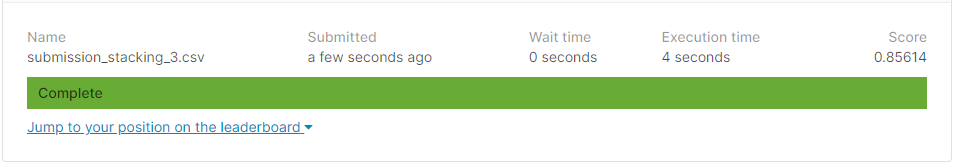

In [ ]:
import xgboost as xgb